In [1]:
import torch
import torch.nn as nn

from hvsrUNet.module.model import UNet
from hvsrUNet.module.trainer import train
from hvsrUNet.module.dataset import MkData
from hvsrUNet.toolbox.plot import plotTest, plotLoss


In [7]:
import glob
import os
import json

path = '../../inSightDataProcess/examples/data_ellip/'
files = os.listdir(path)
for file in files:
    with open(path+file,'r') as f:
        data = json.load(f)


1000

In [8]:
len(data['cpr'])

1000

In [43]:

import numpy as np
from disba import PhaseDispersion           #计算相速度频散
#from disba import GroupDispersion          #计算群速度频散
from disba._helpers import resample 
import matplotlib
from matplotlib import pyplot as plt
import json



sampleNum = 1000
num_h1 = 3
num_h2 = 3
depth_end = 0.2 # km
dx = depth_end / sampleNum
radius = 120
h1_range = np.linspace(0.1, 0.4, 3)
h2_range = np.linspace(0.1, 0.4, 3)
vs1_range = np.linspace(0.5, 0.6, 4)
vs2_range = np.linspace(0.8, 1.0, 4)
vs3_range = np.linspace(0.6, 0.7, 4)

cpr = np.zeros((len(h1_range), len(h2_range), len(vs1_range), len(vs2_range), len(vs3_range), sampleNum))
freq = np.zeros((len(h1_range), len(h2_range), len(vs1_range), len(vs2_range), len(vs3_range), sampleNum))



for i1, h1 in enumerate(h1_range):
    for i2, h2 in enumerate(h2_range):
        for j1, vs1 in enumerate(vs1_range):
            for j2, vs2 in enumerate(vs2_range):
                for j3, vs3 in enumerate(vs3_range):
                    h3 = depth_end - h1 - h2
                    velocity_model = np.array([
                        [h1, 2*vs1, vs1, 2.00],
                        [h2, 2*vs2, vs2, 2.00],
                        [depth_end, 2*vs3, vs3, 2.00]
                    ])

                    ## 0.read velocity model读取速度模型
                    velocity_model_thickness=velocity_model.T[0]

                    ## 0.1.对原始速度模型进行重采样
                    dz = 0.01
                    velocity_model = resample(velocity_model_thickness.T, velocity_model, dz)
                    velocity_model = np.array(velocity_model[1])
                    velocity_model.T[0] = dz


                    # Periods must be sorted starting with low periods
                    t = np.logspace(0.01, 1.2, sampleNum)          #创建等比数列(周期)

                    # Compute the 3 first Rayleigh- and Love- wave modal dispersion curves 计R/L频散曲线
                    # Fundamental mode corresponds to mode 0(基阶mode=0)
                    pd = PhaseDispersion(*velocity_model.T)
                    #pd = GroupDispersion(*velocity_model.T)
                    a = pd(t, mode=0, wave="rayleigh")
                    # a.shape: ((1000,), (1000,), 0, 'rayleigh', 'phase')
                    cpr[i1][i2][j1][j2][j3] = a[1]
                    freq[i1][i2][j1][j2][j3] = 1/a[0]       #周期转换为频率

    #                 break
    #             break
    #         break
    #     break
    # break


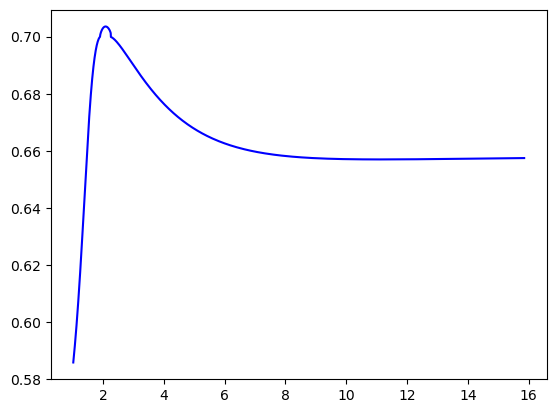

In [55]:
A = np.abs(np.fft.fft(a[1]))
Freq = np.abs(np.fft.fftfreq(len(A), d=a[0][1]-a[0][0]))


#plt.plot(Freq, A, color='orange', label='phase')
plt.plot(a[0], a[1], color='blue', label='phase')

In [1]:
from torch.utils.data import Dataset
from PIL import Image

class DpDataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        self.labels = labels
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # 根据索引获取一张图像和对应的标签
        dataset = self.dataset[index]
        label = self.labels[index]
        
        # # 加载图像并转换为 PyTorch 张量
        # image = Image.open(image_path).convert('RGB')
        # image = transforms.ToTensor()(image)
        
        return dataset, label
